In [156]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/steam-games-dataset/games_may2024_cleaned.csv
/kaggle/input/steam-games-dataset/games_may2024_full.csv
/kaggle/input/steam-games-dataset/games_march2025_full.csv
/kaggle/input/steam-games-dataset/games_march2025_cleaned.csv


In [157]:
df = pd.read_csv('/kaggle/input/steam-games-dataset/games_march2025_full.csv')

In [158]:
# df.info()

In [159]:
# worthy to drop the following features
# most of them are entirely missing
# and eventually causing noise
# notes, support_url, support_email, website
# they are string identifiers/URLs 
# not very useful for XGBoost
# unless we want to establish publisher contact

In [160]:
df = df.drop(columns=['metacritic_url', 'score_rank', 'reviews', 'notes', 'website', 'support_url', 'support_email'], axis=1)

In [161]:
# df.info()

In [162]:
# less to moderate missing values in 
# detailed_description 
# about_the_game
# short_description 

# so, these seems to be long text descriptions
# not worthy when I just want to apply xgboost
# and other ML algorithms

# our goal for now is not NLP but classic 
# classification and regression, so yes, let's go

In [163]:
df = df.drop(columns=['detailed_description', 'about_the_game', 'short_description'], axis=1)

In [164]:
# df.info()

let's one by one talk about objects features "genres", "categories" and "tags" they influence a game's success by guiding player choices,developer decisions and market strategies. they help players find games they will enjoy
inform development decisions, 
and in targeted marketing campaigns

so, i am deciding to keeping them, they seem gold!

then we have "publishers" and "developers" as publishers primarily focus on marketing or promotion and distribution while developers handle the core game creation and development 
so, success rate depends on them alot

game packages, hold both physical packaging and digital formats, play an important role in a game's success by influencing appeal marketing and long-term engagement



In [165]:
df = df.drop(columns=['movies', 'screenshots', 'header_image'])

header_image, screenshots and movies do not hold numeric/tabular features, they are basically links(urls) to the media content. so, not a need to keep as we are not doing computer vision/deep learning yet. 

In [166]:
# df.info()

In [167]:
df['packages'].unique()

array(["[{'title': 'Buy Counter-Strike 2', 'description': '', 'subs': [{'text': 'Counter-Strike 2 - Free', 'description': '', 'price': 0.0}, {'text': 'Prime Status Upgrade - $14.99', 'description': '', 'price': 14.99}]}]",
       '[]',
       "[{'title': 'Buy Dota 2', 'description': '', 'subs': [{'text': 'Dota 2 - Commercial License - Free', 'description': '', 'price': 0.0}]}]",
       ...,
       "[{'title': 'Buy Player One', 'description': '', 'subs': [{'text': 'Player One - $1.99', 'description': '', 'price': 1.99}]}]",
       "[{'title': 'Buy DragonRoad', 'description': '', 'subs': [{'text': 'DragonRoad - $29.99', 'description': '', 'price': 29.99}]}]",
       "[{'title': 'Buy Ragtag Adventurers', 'description': '', 'subs': [{'text': 'Ragtag Adventurers - $9.99', 'description': '', 'price': 9.99}]}]"],
      dtype=object)

i am not going to throw packages away, it seems a goldmine to me. 

"[{'title': 'Buy Counter-Strike 2', 'description': '', 'subs': [{'text': 'Counter-Strike 2 - Free', 'description': '', 'price': 0.0}, {'text': 'Prime Status Upgrade - $14.99', 'description': '', 'price': 14.99}]}]"

here, as we can see sub packages and they are basically editions to me.

we have
1. num_subs = 2 (numbe of sub packages)(int) 
2. minimum_price = 0(free)(float)
3. maximum_price = 14.99(float)
4. has_free_version = 1(bool)

let's do it now 

In [168]:
import pandas as pd
import ast 
import numpy as np

def extract_package_features(package_data):
    # default features
    num_subpackages = 0
    minimum_price = np.nan
    maximum_price = np.nan
    has_free_version = 0
    num_free = 0
    num_paid = 0

    try: 
        # safely parse string into python object
        packages = ast.literal_eval(package_data)
        # it evaluate the data containing python literal 

        if isinstance(packages, list) and len(packages) > 0: 
            # checking if the parsed object is a list and not empty 
            subs = packages[0].get("subs", [])
            prices = [sub.get("price", np.nan) for sub in subs]

            if prices: 
                num_subpackages = len(prices)
                minimum_price = min(prices)
                maximum_price = max(prices)
                num_free = sum(1 for p in prices if p == 0.0)
                num_paid = num_subpackages - num_free
                has_free_version = int(num_free > 0)

    except (ValueError, SyntaxError): 
        pass

    return num_subpackages, minimum_price, maximum_price,has_free_version, num_free, num_paid
                

In [169]:
extract_package_features(df['packages'].iloc[0])

(2, 0.0, 14.99, 1, 1, 1)

now, let's apply this to all the rows

In [170]:
df[["number_of_subpackages", "minimum_price", "maximum_price", "has_free_version", "number_of_free_edition", "number_of_paid_edition"]] = (
    df["packages"].apply(lambda x : pd.Series(extract_package_features(x)))
)

In [171]:
df['maximum_price'] = df['maximum_price'].fillna(0)

In [172]:
df['minimum_price'] = df['minimum_price'].fillna(0)

In [173]:
# df.info()

In [174]:
df['genres'].values

array(["['Action', 'Free To Play']",
       "['Action', 'Adventure', 'Massively Multiplayer', 'Free To Play']",
       "['Action', 'Strategy', 'Free To Play']", ...,
       "['Indie', 'Early Access']",
       "['Adventure', 'RPG', 'Simulation', 'Strategy']",
       "['Action', 'Indie']"], dtype=object)

In [175]:
df['categories'].values

array(["['Multi-player', 'Cross-Platform Multiplayer', 'Steam Trading Cards', 'Steam Workshop', 'In-App Purchases', 'Valve Anti-Cheat enabled', 'Stats', 'Remote Play on Phone', 'Remote Play on Tablet', 'Remote Play on TV', 'Steam Timeline']",
       "['Multi-player', 'PvP', 'Online PvP', 'Stats', 'Remote Play on Phone', 'Remote Play on Tablet']",
       "['Multi-player', 'Co-op', 'Steam Trading Cards', 'Steam Workshop', 'SteamVR Collectibles', 'In-App Purchases', 'Valve Anti-Cheat enabled', 'Steam Timeline']",
       ..., "['Single-player', 'Family Sharing']",
       "['Single-player', 'Multi-player', 'PvP', 'Online PvP', 'Co-op', 'Online Co-op', 'Steam Achievements', 'Full controller support', 'Captions available', 'Steam Cloud', 'Stats', 'Steam Leaderboards', 'Remote Play on TV', 'Remote Play Together', 'Family Sharing']",
       "['Single-player', 'Multi-player', 'PvP', 'Online PvP', 'Shared/Split Screen PvP', 'Co-op', 'Online Co-op', 'Shared/Split Screen Co-op', 'Shared/Split Scree

it is stored as a stringified python list. which is enough of a hustle. 

solution is 
1. parse the string into a real python list
2. now converting it into multi-hot encoded features

In [176]:
df['categories'] = df['categories'].apply(lambda x : ast.literal_eval(x) if pd.notnull(x) else [])

In [177]:
df['categories']

0        [Multi-player, Cross-Platform Multiplayer, Ste...
1        [Multi-player, PvP, Online PvP, Stats, Remote ...
2        [Multi-player, Co-op, Steam Trading Cards, Ste...
3        [Single-player, Multi-player, PvP, Online PvP,...
4        [Single-player, Multi-player, PvP, Online PvP,...
                               ...                        
94943    [Single-player, Steam Achievements, Stats, Ste...
94944                      [Single-player, Family Sharing]
94945                      [Single-player, Family Sharing]
94946    [Single-player, Multi-player, PvP, Online PvP,...
94947    [Single-player, Multi-player, PvP, Online PvP,...
Name: categories, Length: 94948, dtype: object

converting into multi-hot encoded features

In [178]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
categories_encoded = mlb.fit_transform(df['categories'])

df_categories = pd.DataFrame(categories_encoded, columns=mlb.classes_, index=df.index)
df = pd.concat([df, df_categories], axis=1)

In [179]:
df = df.drop(columns = ['categories'])

In [180]:
# df.info()

In [181]:
df['tags'].unique()

array(["{'FPS': 90857, 'Shooter': 65397, 'Multiplayer': 62332, 'Competitive': 53359, 'Action': 47512, 'Team-Based': 46430, 'e-sports': 43533, 'Tactical': 41354, 'First-Person': 39414, 'PvP': 34470, 'Online Co-Op': 33966, 'Co-op': 30263, 'Strategy': 30111, 'Military': 28699, 'War': 28006, 'Difficult': 25966, 'Trading': 25717, 'Realistic': 25430, 'Fast-Paced': 25318, 'Moddable': 6603}",
       "{'Survival': 14838, 'Shooter': 12727, 'Battle Royale': 10877, 'Multiplayer': 10837, 'FPS': 8428, 'PvP': 7703, 'Third-Person Shooter': 7322, 'Action': 6013, 'Online Co-Op': 5368, 'Tactical': 5058, 'Co-op': 4336, 'First-Person': 4090, 'Strategy': 3121, 'Early Access': 2829, 'Competitive': 2437, 'Third Person': 2369, 'Team-Based': 2090, 'Difficult': 1750, 'Simulation': 1390, 'Stealth': 1297}",
       "{'Free to Play': 59933, 'MOBA': 20158, 'Multiplayer': 15359, 'Strategy': 14252, 'e-sports': 11780, 'Team-Based': 10962, 'Competitive': 8286, 'Action': 7920, 'Online Co-Op': 7464, 'PvP': 6046, 'Difficult

dictionary stored as a string for each game. keys are tags and values is the number of times players applied the tag(tag frequency/popularity), they hold weights(counts), not just presence but how strongly the community associates with the game with the tag, so information rich feature. 


1. so,the idea is that we pick up the top N tags and compute their frequency, it avoids alot of useless information.
2. weighted features, for each game, create a feature column for each top-N tag.
3. if tag not present, is 0 else the value.
4. other tags in another column, simple.
5. dropping the original string tags after extraction. 

In [182]:
from collections import Counter

# 1. parse tags column from string to dictionary 
def parse_tags(tag_string): 
    try: 
        parsed = ast.literal_eval(tag_string)
        # parsing the tag_string 
        # checking if it is a list now
        if isinstance(parsed, list): 
            merged = {}
            for d in parsed: 
                if isinstance(d, dict): 
                    merged.update(d)
            return merged
        elif isinstance(parsed, dict): 
            return parsed
        else: 
            return {}
    except (ValueError, SyntaxError): 
        return {}

df['tags_dict'] = df['tags'].apply(parse_tags)

# 2. count overall frequency of all tags
all_tags = Counter() #to count occurrences of keys

for tags in df['tags_dict']: 
    all_tags.update(tags) #adds the count from that row to the total counter

# 3. pick top-N tags
Top_N = 50
top_tags = [tag for tag, count in all_tags.most_common(Top_N)] #to get most frequent one

# 4. create numeric columns for Top-N tags
for tag in top_tags: 
    df[f'tag_{tag}'] = df['tags_dict'].apply(lambda x: x.get(tag, 0))




In [183]:
df = df.drop(columns=['tags_dict', 'tags'])

In [184]:
df['genres'].unique()

array(["['Action', 'Free To Play']",
       "['Action', 'Adventure', 'Massively Multiplayer', 'Free To Play']",
       "['Action', 'Strategy', 'Free To Play']", ...,
       "['Action', 'Indie', 'Simulation', 'Education', 'Game Development']",
       "['Design & Illustration', 'Education', 'Game Development']",
       "['Violent', 'Action', 'Early Access']"], dtype=object)

genres are also stored as stringified lists. 


In [185]:
import ast 
from sklearn.preprocessing import MultiLabelBinarizer

# parse string to list 
df['genres_list'] = df['genres'].apply(lambda x : ast.literal_eval(x) if pd.notnull(x) else [])

# multi-hot encode
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df['genres_list'])

df_genres = pd.DataFrame(genres_encoded, columns=mlb.classes_, index=df.index)
df = pd.concat([df, df_genres], axis=1)



In [186]:
df = df.drop(columns=['genres', 'genres_list'])

In [187]:
# df.columns.tolist()

In [188]:
import ast 
df['publishers'] = df['publishers'].apply(lambda x : ast.literal_eval(x))

In [189]:
# explode publishers into separate rows
publishers_exploded = df[['appid', 'publishers']].explode('publishers')
# explode takes lists in a column and makes one row per item

# appid     publishers
# 1        ['Valve']
#2         ['Rockstar Games', 'Take-Two']
#3         []

# becomes
# appid    publishers
#1         Valve
#2         Rockstar Games
#3         Take-Two
#4         NaN

# we did this to make the counting publishers easier. 

# count frequencies of publishers
publishers_count = publishers_exploded['publishers'].value_counts()
# counts how many times each publisher appear
# across all games

# for example 
# Valve 120 
# Rockstar Games 85
# Electronic Arts 72
# Take-Two 65 ..... and it goes on and on. 

top_50_publishers = publishers_count.head(50).index.tolist()
# takes top 50 most common publishers. 

# create binary indicator columns 

for pub in top_50_publishers: 
    df[f'publisher_{pub}'] = df['publishers'].apply(lambda pubs : int(pub in pubs))

In [190]:
from sklearn.preprocessing import MultiLabelBinarizer


mlb = MultiLabelBinarizer(classes=top_50_publishers)
publishers_encoded = mlb.fit_transform(df['publishers'])

df_publishers = pd.DataFrame(publishers_encoded, columns=mlb.classes_, index=df.index)
df = pd.concat([df, df_publishers], axis=1)

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94948 entries, 0 to 94947
Columns: 260 entries, appid to Shiravune
dtypes: bool(3), float64(7), int64(242), object(8)
memory usage: 186.4+ MB


In [192]:
# df.columns.tolist()

developers, publishers

In [193]:
df = df.drop(columns=['publishers'], axis=1)

before moving further, may we check about how many categorical columns are left in our dataframe

In [194]:
# 1. show all the categorical(object/string) columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)

Index(['name', 'release_date', 'supported_languages', 'full_audio_languages',
       'packages', 'developers', 'estimated_owners'],
      dtype='object')


In [195]:
df = df.drop(columns=['packages'], axis=1)

now, we removed publishers and did multi hot encoding on it, it is the time for developers

In [196]:
# df['developers'].tolist()

as we can clearly see that the developers column is stringified list. so, let's go clean it and get integer columns out of this categorical columns. 

In [197]:
import ast 
import pandas as pd

# 1. convert stringified lists into python lists
df['developers'] = df['developers'].apply(
    lambda x : ast.literal_eval(x) if isinstance(x, str) else x
)

# 2. replace empty lists with ['Unknown']
# we can deal with it 
df['developers'] = df['developers'].apply(
    lambda x : x if len(x) > 0 else ['Unknown']
)

#3. explode for counting frequencies
df_dev_exploded = df.explode('developers')

# 4. too much of a mess so let's pick up, top 50 developer? 
top_n = 50
top_devs = df_dev_exploded['developers'].value_counts().head(top_n).index.tolist()

# 5. final, multi hot encoding for top developers
for dev in top_devs: 
    df[f'dev_{dev}'] = df['developers'].apply(lambda devs : int(dev in devs))



In [198]:
df = df.drop(columns=['developers'], axis=1)

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94948 entries, 0 to 94947
Columns: 307 entries, appid to dev_Octo Games
dtypes: bool(3), float64(7), int64(292), object(5)
memory usage: 220.5+ MB


In [200]:
# 1. show all the categorical(object/string) columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)

Index(['name', 'release_date', 'supported_languages', 'full_audio_languages',
       'estimated_owners'],
      dtype='object')


feature engineering for release date, i feel that it could be important as older games may show up with more positive reviews or maybe newer games are more expensive

In [201]:
type(df['release_date'].iloc[0])

str

In [202]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
# using errors='coerce', if we do not have unparseable string 
# to be just on the safer side. 

# year, monthly, weekday
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['release_dayofweek'] = df['release_date'].dt.dayofweek

df = df.drop(columns=['release_date'], axis=1)

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94948 entries, 0 to 94947
Columns: 309 entries, appid to release_dayofweek
dtypes: bool(3), float64(7), int32(3), int64(292), object(4)
memory usage: 220.9+ MB


name is just an identifier, potential noise

In [204]:
df = df.drop(columns=['name'], axis=1)

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94948 entries, 0 to 94947
Columns: 308 entries, appid to release_dayofweek
dtypes: bool(3), float64(7), int32(3), int64(292), object(3)
memory usage: 220.1+ MB


In [206]:
# 1. show all the categorical(object/string) columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)

Index(['supported_languages', 'full_audio_languages', 'estimated_owners'], dtype='object')


In [207]:
# df['estimated_owners'].tolist()

let us deal with estimated owners, it is actually a continuous popularity signal. 

here, i will keep the log of owners and mid too, then will find out what's better. i don't know the future just experimenting. 

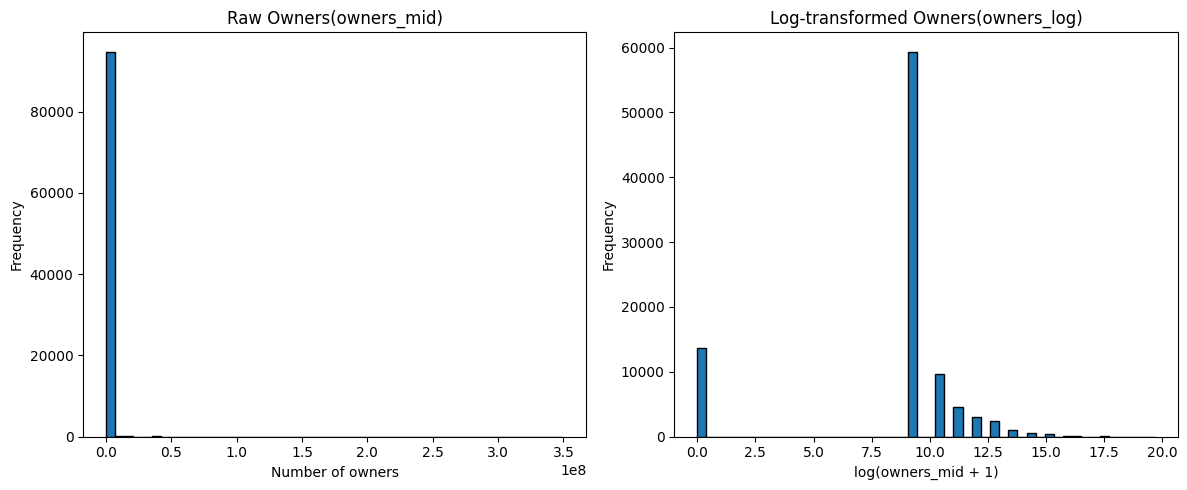

In [208]:
import matplotlib.pyplot as plt
def parse_owners(owners_str): 
    try: 
        low, high = owners_str.replace(",", "").split(" - ")
        return (int(low) + int(high)) // 2
    except: 
        return None

# 1. calculate owners_mid
df['owners_mid'] = df['estimated_owners'].apply(parse_owners)

# 2. log transform(adding +1 to avoid log(0))
df['owners_log'] = np.log1p(df['owners_mid'])

# 3. plot distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['owners_mid'].dropna(), bins=50, edgecolor='black')
plt.title('Raw Owners(owners_mid)')
plt.xlabel("Number of owners")
plt.ylabel("Frequency")


plt.subplot(1, 2, 2)
plt.hist(df['owners_log'].dropna(), bins=50, edgecolor='black')
plt.title('Log-transformed Owners(owners_log)')
plt.xlabel("log(owners_mid + 1)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

as we can clearly see, no big change is visible just a bit tweaked value, that's it. but we kind of normalised skeweness of the data. 

In [209]:
df=df.drop(columns=['owners_mid'], axis=1)

In [210]:
df=df.drop(columns=['estimated_owners'], axis=1)

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94948 entries, 0 to 94947
Columns: 308 entries, appid to owners_log
dtypes: bool(3), float64(8), int32(3), int64(292), object(2)
memory usage: 220.1+ MB


In [212]:
# 1. show all the categorical(object/string) columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)

Index(['supported_languages', 'full_audio_languages'], dtype='object')


let us drop the above two columns and move further as we already have 308 columns, just for experimental purposes, let's go

In [213]:
df = df.drop(columns=['supported_languages', 'full_audio_languages'], axis=1)

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94948 entries, 0 to 94947
Columns: 306 entries, appid to owners_log
dtypes: bool(3), float64(8), int32(3), int64(292)
memory usage: 218.7 MB


In [215]:
from sklearn.model_selection import train_test_split 
from xgboost import XGBRegressor

In [216]:
x = df.drop(columns=['price', 'appid']) 
# let's choose target
y = df['price']


In [217]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)



In [218]:
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05, 
    max_depth=6, 
    subsample=0.8, #to decide the fraction of training sample to be used
    random_state=42
)

In [219]:
from datetime import datetime

start = datetime.now()
# train 
model.fit(x_train, y_train)
end = datetime.now()
print("time taken to train", end - start)

time taken to train 0:00:14.682661


In [220]:
y_pred = model.predict(x_test)

In [221]:
# evaluate 
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
print("root mean squared error : ", np.sqrt(mse))

r_two_score = r2_score(y_test, y_pred)
print("r2 score : ", r_two_score)

root mean squared error :  2.7604357711664176
r2 score :  0.9527157349817514


let's see what features are impacting our price

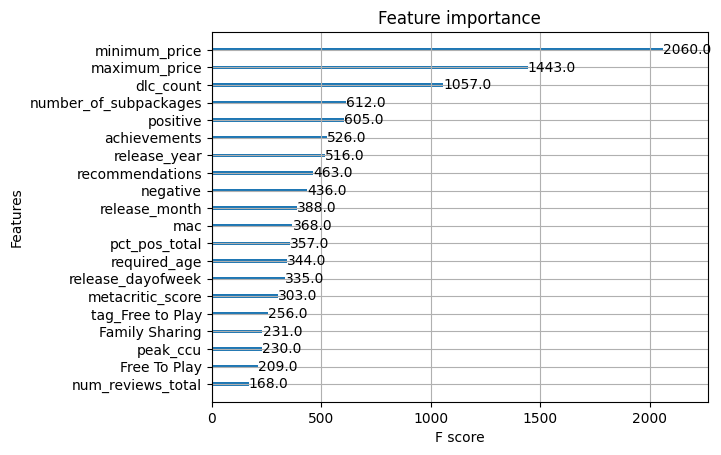

In [222]:
from xgboost import plot_importance
import matplotlib.pyplot as plt 

plot_importance(model, max_num_features=20)
plt.show()

In [223]:
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(model, x, y, cv=5, scoring='neg_mean_squared_error')
print(np.sqrt(-cv_score))

[3.10079394 0.93697469 5.86988615 9.43025592 5.75076995]


you can see, model is a bit overfitting. so, let's hypertune it. 

In [224]:
param_grid = {
    "max_depth" : [3, 5, 7], 
    "min_child_weight" : [1, 3, 5], #minimum sum of instance weight
    "subsample" : [0.6, 0.8, 1.0], #row sampling 
    "colsample_bytree" : [0.6, 0.8, 1.0],  #feature sampling
    "n_estimators" : [200, 500], 
    "learning_rate" : [0.01, 0.1, 0.3] #eta
}

In [225]:
from sklearn.model_selection import RandomizedSearchCV

In [226]:
random_search = RandomizedSearchCV(
    estimator = model, 
    param_distributions = param_grid,
    scoring = "neg_root_mean_squared_error", #we want rmse
    cv = 3, 
    verbose=2,
    n_jobs=-1
)

In [227]:
random_search.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=500,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [200, 500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='neg_root_mean_squared_error', verbose=2)

In [228]:
random_search.best_params_

{'subsample': 0.8,
 'n_estimators': 200,
 'min_child_weight': 3,
 'max_depth': 5,
 'learning_rate': 0.1,
 'colsample_bytree': 0.8}

In [229]:
# now, testing performance with the best model 
best_model = random_search.best_estimator_ 
y_pred = best_model.predict(x_test)

In [230]:
print("test rmse : ", np.sqrt(mean_squared_error(y_test, y_pred)))
print('test r2 : ', r2_score(y_test, y_pred))

test rmse :  2.983217780316186
test r2 :  0.9447755667893499


now let's apply cross val score

In [231]:
cv_scores = cross_val_score(best_model, x, y, cv=5, scoring='neg_root_mean_squared_error')
print('cross valid rmse : ', np.sqrt(-cv_scores))

cross valid rmse :  [1.74080512 1.15650273 2.66945531 2.85838021 2.17714851]


should we go with feature importance? 

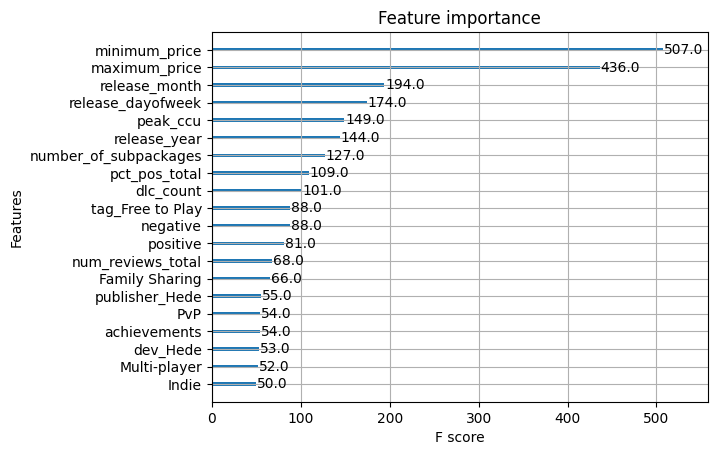

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, min_child_weight=1, n_estimators=500, subsample=0.8; total time=  46.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=200, subsample=1.0; total time=  23.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.8; total time=  15.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, subsample=0.6; total time=  34.1s
[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=200, subsample=1.0; total time=  14.2s
[CV] END colsample_bytree=0.6, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=200, subsample=1.0; total time=  14.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.8; total time=  26.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, ma

In [232]:
import matplotlib.pyplot as plt 
import xgboost as xgb

# feature importance 
xgb.plot_importance(best_model, importance_type='weight', max_num_features=20)
plt.show()